In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time
import unidecode
from googletrans import Translator

In [2]:
with open('data/final/sampled_references_ja.json','r',encoding='utf-8') as f:
    json_ja = json.load(f)
    df = pd.DataFrame(json_ja)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    s1 = unidecode.unidecode(norm_string(s1))
    s2 = unidecode.unidecode(norm_string(s2))
    return textdistance.levenshtein.normalized_similarity(s1,s2)

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(100)

,index,netloc
0,ja.wikipedia.org,141
1,viaf.org,132
2,talent.yahoo.co.jp,18
3,npb.jp,11
4,kanji.jitenon.jp,6
5,ci.nii.ac.jp,2
6,web.archive.org,2
7,www.isfdb.org,2
8,cbdb.fas.harvard.edu,1
9,www.azumi-ghp.jp,1


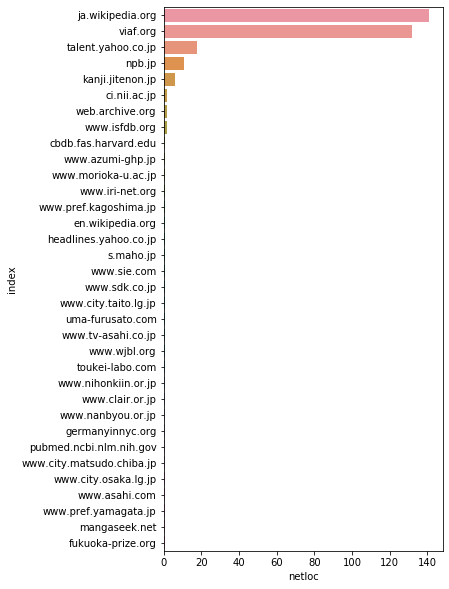

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## viaf.org

In [6]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

WorldCat 識別ID    72
VIAF識別子          15
NTA PPN 識別子      12
国立国会図書館典拠ID       7
生年月日              7
BNF               6
SUDOC             4
NKC識別子            3
LCNAF識別子          3
ISNI              1
NUKAT             1
LNB識別子            1
Name: predicate, dtype: int64

In [7]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    try:
        if type(d['mainHeadings']['data']) is not list:
            d['mainHeadings']['data']= [d['mainHeadings']['data']]
        names = [name['text'] for name in d['mainHeadings']['data']]
        for to_add in ['mainHeadings/mainHeadingEl','x400s/x400','x500s/x500']:
            to_add = to_add.split('/')
            if to_add[0] in d:
                if type(d[to_add[0]][to_add[1]]) != list:
                    d[to_add[0]][to_add[1]] = [d[to_add[0]][to_add[1]]]
                names_i = [i['datafield']['subfield'] for i in d[to_add[0]][to_add[1]]]
                names_i = [n if type(n) == list else [n] for n in names_i]
                names_i = [item['#text'] for sublist in names_i for item in sublist]
                names += names_i
    except Exception:
        print(url)
        print(d)
        raise

    if all([compare(subject,name) < 0.9 for name in names]):
        if verbose:
            print(url)
            print(subject)
            print(names)
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'BNF':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj.startswith(value):
            found = True
    elif predicate == 'WorldCat 識別ID':
        #print('xLinks is',xLinks)
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    elif predicate == 'NTA PPN 識別子':
        value = [i for i in flat_ids if i.startswith('NTA|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == '国立国会図書館典拠ID':
        value = [i for i in flat_ids if i.startswith('NDL|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'VIAF識別子':
        if obj in [viaf_id]:
            found = True
    elif predicate == '生年月日':
        value = d['birthDate']
        if obj.startswith(value):
            found = True
    elif predicate == 'ISNI':
        value = [i for i in flat_ids if i.startswith('ISNI|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True    
    elif predicate == 'LNB識別子':
        value = [i for i in flat_ids if i.startswith('LNB|LNC10-')][0].split('|LNC10-')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True    
    elif predicate == 'SUDOC':
        value = [i for i in flat_ids if i.startswith('SUDOC|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True    
    elif predicate == 'LCNAF識別子':
        value = [i for i in flat_ids if i.startswith('LC|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True    
    elif predicate == 'NKC識別子':
        value = [i for i in flat_ids if i.startswith('NKC|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True    
    elif predicate == 'NUKAT':
        value = [i for i in flat_ids if i.startswith('NUKAT|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    else:
        value = 'predicate not treated'
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        print(flat_ids)
        print('-'*20)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf[df_viaf_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

http://www.viaf.org/viaf/253351577/viaf.json
WorldCat 識別ID
lccn-no2001017021
viaf-253351577
['WKP|Q17191551', 'NDL|001136214', 'NDL|01028024']
--------------------
99.24242424242425% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
54,bcd9ef725404b0bb51f383a37d34f7a1c9c60689,https://viaf.org/viaf/253351577,{'VIAF ID': 'value:>253351577'},ja,Q766580-BDF10C41-5BC0-4FBB-9977-5407702B43DF,Adon,WorldCat 識別ID,lccn-no2001017021,0,False,https,viaf.org,/viaf/253351577,,,


# Save files

In [8]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_ja if j['reference_id'] in not_verified_reference_ids]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_ja_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 209. That is 61.470588235294116% left from the total.


In [9]:
df[df['verified'] == False]['netloc'].value_counts()

ja.wikipedia.org             141
talent.yahoo.co.jp            18
npb.jp                        11
kanji.jitenon.jp               6
web.archive.org                2
ci.nii.ac.jp                   2
www.isfdb.org                  2
www.azumi-ghp.jp               1
www.morioka-u.ac.jp            1
www.tv-asahi.co.jp             1
www.nanbyou.or.jp              1
en.wikipedia.org               1
www.pref.kagoshima.jp          1
www.nihonkiin.or.jp            1
www.iri-net.org                1
www.wjbl.org                   1
s.maho.jp                      1
www.sie.com                    1
www.sdk.co.jp                  1
www.city.taito.lg.jp           1
uma-furusato.com               1
viaf.org                       1
toukei-labo.com                1
mangaseek.net                  1
www.clair.or.jp                1
headlines.yahoo.co.jp          1
germanyinnyc.org               1
pubmed.ncbi.nlm.nih.gov        1
www.city.matsudo.chiba.jp      1
www.city.osaka.lg.jp           1
www.asahi.

In [10]:
def is_wikipedia(url):
    if url.startswith('https://ja.wikipedia.org'):
        return True
    elif url.startswith('https://en.wikipedia.org'):
        return True
    return False

not_verified_references_non_wikipedia = [r for r in not_verified_references if not is_wikipedia(r['url'])]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_ja_auth.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references_non_wikipedia,f ,indent=2,ensure_ascii=False)